In [1]:
import numpy as np
import sys
import os
from pathlib import Path

# root = Path("D:/VG3")
# s2p_green = Path("Z:/data/PROC/VG1/2024_08_28/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG1/2024_08_28/2")
# s2p_green = Path("Z:/data/PROC/VG1/2024_08_29/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG1/2024_08_29/2")

# s2p_green = Path("Z:/data/PROC/VG3/2024_08_29/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG3/2024_08_29/1")
# s2p_green = Path("Z:/data/PROC/VG4/2024_08_29/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG4/2024_08_29/1")
# s2p_green = Path("Z:/data/PROC/VG5/2024_08_29/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG5/2024_08_29/2")
# ABACG_PQ_2340
# s2p_green = Path("Z:/data/PROC/VG1/2024_08_31/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG1/2024_08_31/1")
# s2p_green = Path("Z:/data/PROC/VG5/2024_08_31/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG5/2024_08_31/1")
# s2p_green = Path("Z:/data/PROC/VG3/2024_08_31/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG3/2024_08_31/1")
# s2p_green = Path("Z:/data/PROC/VG4/2024_08_31/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG4/2024_08_31/1")
# after learning: ABACG_PQ_2340
# s2p_green = Path("Z:/data/PROC/VG5/2024_09_06/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG5/2024_09_06/1")
# s2p_green = Path("Z:/data/PROC/VG1/2024_09_06/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG1/2024_09_06/2")
# s2p_green = Path("Z:/data/PROC/VG3/2024_09_06/3/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG3/2024_09_06/1")
# s2p_green = Path("Z:/data/PROC/VG4/2024_09_06/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG4/2024_09_06/1")

# s2p_green = Path("Z:/data/PROC/VG1/2024_09_09/4/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG1/2024_09_09/3")
# s2p_green = Path("Z:/data/PROC/VG4/2024_09_09/2/suite2p")
# s2p_red = Path("Y:/QQZ/raw_DATA/VG4/2024_09_09/1")
s2p_green = Path("Z:/data/PROC/VG5/2024_09_09/3/suite2p")
s2p_red = Path("Y:/QQZ/raw_DATA/VG5/2024_09_09/2")

In [2]:
from suite2p import default_ops
from suite2p.io import tiff
import imp
imp.reload(tiff)
import json

### convert red/green tiffs to binary files
ops = default_ops()
ops["data_path"] = [s2p_red]#[root / s2p_red]
ops["nchannels"] = 2
ops["save_path0"] = str(ops["data_path"][0])

ops = tiff.tiff_to_binary(ops)

c:\Users\labadmin\anaconda3\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\labadmin\AppData\Local\Temp\ipykernel_19704\1414977374.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


tif
** Found 8 tifs - converting to binary **
2000 frames of binary, time 22.87 sec.
4000 frames of binary, time 45.73 sec.
6000 frames of binary, time 73.54 sec.


In [3]:
from suite2p.registration import register
import contextlib 
from suite2p import io
from natsort import natsorted 
import imp
imp.reload(register)

### align red/green recording to green recording

# get plane folders
ops["save_folder"] = "suite2p"
save_folder = os.path.join(ops["save_path0"], ops["save_folder"])
plane_folders = natsorted(
    [
        f.path
        for f in os.scandir(save_folder)
        if f.is_dir() and f.name[:5] == "plane"
    ]
)
ops_paths = [os.path.join(f, "ops.npy") for f in plane_folders]
nplanes = len(ops_paths)

# get reference images from long green recording
ops_paths_green = [str(s2p_green / f"plane{ipl}" / "ops.npy") 
                   for ipl in range(nplanes)]
refImgs = [np.load(ops_path, allow_pickle=True).item()["meanImg"] 
           for ops_path in ops_paths_green]


In [4]:

# loop over planes
align_by_chan2 = False
for ipl, ops_path in enumerate(ops_paths):
    print(ops_path)
    if ipl in ops["ignore_flyback"]:
        print(">>>> skipping flyback PLANE", ipl)
        continue
    else:
        print(">>>> registering PLANE", ipl)
    ops = np.load(ops_path, allow_pickle=True).item()
    # get binary file paths
    raw = ops.get("keep_movie_raw") and "raw_file" in ops and os.path.isfile(
        ops["raw_file"])
    reg_file = ops["reg_file"]
    raw_file = ops.get("raw_file", 0) if raw else reg_file
    # get number of frames in binary file to use to initialize files if needed
    if ops["nchannels"] > 1:
        reg_file_chan2 = ops["reg_file_chan2"]
        raw_file_chan2 = ops.get("raw_file_chan2", 0) if raw else reg_file_chan2
    else:
        reg_file_chan2 = reg_file
        raw_file_chan2 = reg_file

    # shape of binary files
    n_frames, Ly, Lx = ops["nframes"], ops["Ly"], ops["Lx"]

    null = contextlib.nullcontext()
    twoc = ops["nchannels"] > 1

    with io.BinaryFile(Ly=Ly, Lx=Lx, filename=raw_file, n_frames=n_frames) \
        if raw else null as f_raw, \
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=reg_file, n_frames=n_frames) as f_reg, \
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=raw_file_chan2, n_frames=n_frames) \
        if raw and twoc else null as f_raw_chan2,\
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=reg_file_chan2, n_frames=n_frames) \
        if twoc else null as f_reg_chan2:
            f_alt_in, f_align_out, f_alt_out = None, None, None
            print(ops["ops_path"], f_reg.filename)
            registration_outputs = register.registration_wrapper(
                f_reg, f_raw=f_raw, f_reg_chan2=f_reg_chan2, f_raw_chan2=f_raw_chan2,
                refImg=refImgs[ipl], align_by_chan2=align_by_chan2, ops=ops)

            ops = register.save_registration_outputs_to_ops(registration_outputs, ops)
            
            meanImgE = register.compute_enhanced_mean_image(
            ops["meanImg"].astype(np.float32), ops)
            ops["meanImgE"] = meanImgE
    np.save(ops["ops_path"], ops)




Y:\QQZ\raw_DATA\VG5\2024_09_09\2\suite2p\plane0\ops.npy
>>>> registering PLANE 0
Y:\QQZ\raw_DATA\VG5\2024_09_09\2\suite2p\plane0\ops.npy Y:\QQZ\raw_DATA\VG5\2024_09_09\2\suite2p\plane0\data.bin
registering two channels
Registered 500/3634 in 11.52s
Registered 1000/3634 in 21.70s
Registered 1500/3634 in 30.87s
Registered 2000/3634 in 40.09s
Registered 2500/3634 in 49.20s
Registered 3000/3634 in 59.27s
Registered 3500/3634 in 72.20s
Registered 3634/3634 in 75.07s
Second channel, Registered 500/3634 in 4.61s
Second channel, Registered 1000/3634 in 10.30s
Second channel, Registered 1500/3634 in 17.25s
Second channel, Registered 2000/3634 in 23.21s
Second channel, Registered 2500/3634 in 29.36s
Second channel, Registered 3000/3634 in 35.22s
Second channel, Registered 3500/3634 in 40.57s
Second channel, Registered 3634/3634 in 41.90s


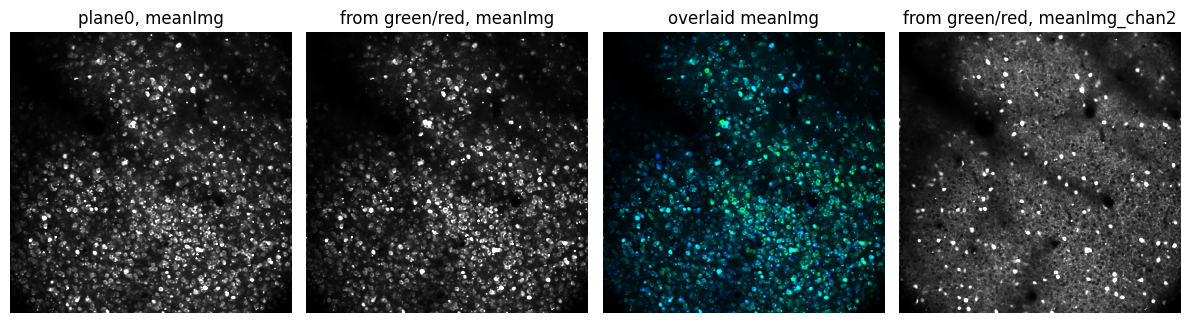

In [5]:
### check alignment
import matplotlib.pyplot as plt
from cellpose.transforms import normalize99

fig = plt.figure(figsize=(12,12))

for ipl in range(nplanes):
    ops = np.load(ops_paths[ipl], allow_pickle=True).item()
    ops_green = np.load(ops_paths_green[ipl], allow_pickle=True).item()
    plt.subplot(nplanes, 4, 1 + ipl*4)
    plt.imshow(normalize99(ops_green["meanImg"]), vmin=0, vmax=1, cmap="gray")
    plt.title(f"plane{ipl}, meanImg")
    plt.axis("off")
    
    plt.subplot(nplanes, 4, 2 + ipl*4)
    plt.imshow(normalize99(ops["meanImg"]), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.title(f"from green/red, meanImg")
    
    rgb = np.zeros((*ops["meanImg"].shape, 3))
    rgb[:,:,1] = np.clip(normalize99(ops["meanImg"]), 0, 1)
    rgb[:,:,2] = np.clip(normalize99(ops_green["meanImg"]), 0, 1)
    plt.subplot(nplanes, 4, 3 + ipl*4)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"overlaid meanImg")
    
    plt.subplot(nplanes, 4, 4 + ipl*4)
    plt.imshow(normalize99(ops["meanImg_chan2"]), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.title(f"from green/red, meanImg_chan2")
plt.tight_layout()


In [6]:
### get red channel overlap with green

from suite2p.detection import chan2detect, anatomical
imp.reload(anatomical)
imp.reload(chan2detect)

stat_paths_green = [str(s2p_green / f"plane{ipl}" / "stat.npy") 
                   for ipl in range(nplanes)]
redcell_paths_green = [str(s2p_green / f"plane{ipl}" / "redcell.npy") 
                   for ipl in range(nplanes)]

for ipl, ops_path in enumerate(ops_paths):
    print(ops_path)
    ops = np.load(ops_path, allow_pickle=True).item()
    stat = np.load(stat_paths_green[ipl], allow_pickle=True)

    ops, redstats = chan2detect.detect(ops, stat)

    np.save(ops_path, ops)
    
    opsg = np.load(ops_paths_green[ipl], allow_pickle=True).item()
    opsg["meanImg_chan2"] = ops["meanImg_chan2"]
    opsg["meanImg_chan2_corrected"] = ops["meanImg_chan2_corrected"]
    opsg["nchannels"] = 2

    np.save(ops_paths_green[ipl], opsg)
    np.save(redcell_paths_green[ipl], redstats)


Y:\QQZ\raw_DATA\VG5\2024_09_09\2\suite2p\plane0\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates


In [7]:
### save new combined ops and redcell
from suite2p.io.save import combined

combined(str(s2p_green));


appended plane 0 to combined view
